In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Configurando estilos
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
directory = '..\\data\\processed'
parquet_file = [file for file in os.listdir(directory) if file.endswith('.parquet')][0]

In [3]:
parquet_dir = os.path.join(directory, parquet_file)
print(parquet_dir)

..\data\processed\concatenated_dfs.parquet


In [4]:
master = pd.read_parquet(parquet_dir)

In [5]:
len(master)

280901

In [6]:
# Calcular log de price para melhor trabalhar com a feature, minimizando valores outliers 
master['log_price'] = np.log(master.price)

## Trabalhando com a coluna descritpion

In [7]:
df = master.copy()

### Principais metas e to-dos
- Fazer uma classificação pelo tamanho da string e visualizar se isso tem influência no preço ou nota - Done
- Calcular a frequência das palavras por meio da criação de um bag of words e TFIDF vectorizer - TbD
- Aplicar o Vader - Sentiment analysis
- API Open AI
- Buscar outros métodos

#### String Lenght

In [8]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'log_price'],
      dtype='object')

In [14]:
df.description.sample(10)

132954    Aromas of baked plum, cherry under spirits, oa...
63614     An earthy, Indian-inspired spice rack of scent...
213025    Soft and rounded, this has apple and peach fru...
242776    The nose starts nicely, with plenty of plum an...
87666     Pure fruit with some concentration, this wine ...
75134     This is a nicely constructed Shiraz with some ...
239724    Sweet plum, raisin and chocolate work the welc...
192351    A vintage-dated Prosecco with a festive, bubbl...
36958     With a light red color, tantalizing oak and ra...
161809    It's herbal, grassy and thin. There's a good f...
Name: description, dtype: object

In [22]:
df['description_length'] =  df['description'].str.len()

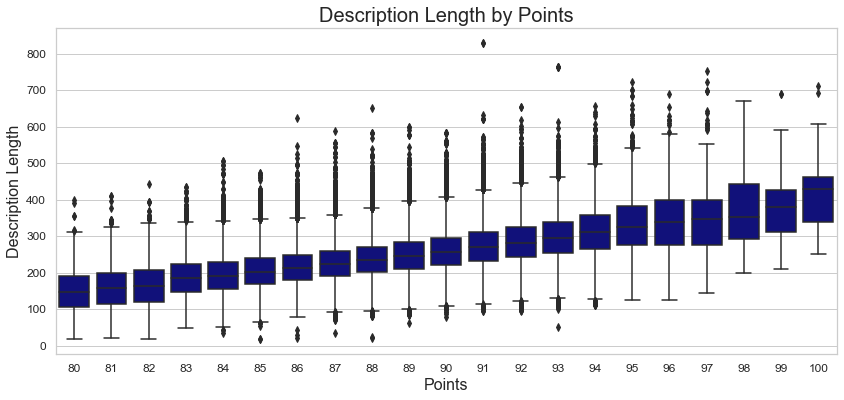

In [23]:
plt.figure(figsize=(14,6))
sns.boxplot(x='points', y='description_length', data=df,
                color='darkblue')
plt.title('Description Length by Points', fontsize=20)
plt.ylabel('Description Length', fontsize = 16) # Y label
plt.xlabel('Points', fontsize = 16) # X label
plt.show()

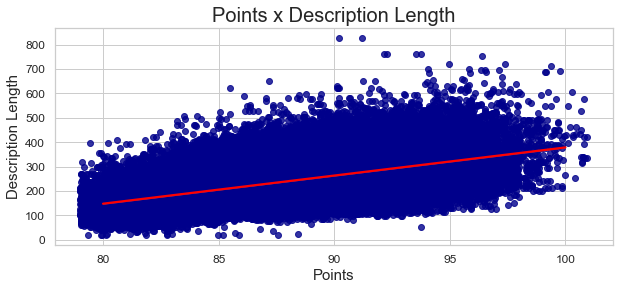

In [24]:
plt.figure(figsize=(10,4))
sns.regplot(x='points', y='description_lenght', 
                data=df, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='darkblue')
plt.title("Points x Description Length", fontsize=20)
plt.xlabel("Points", fontsize= 15)
plt.ylabel("Description Length", fontsize= 15)

plt.show()

Quanto mais extensa a descrição do texto, melhor é a nota associada ao vinho.

#### E se eu fizer a contagem de palavras?

In [26]:
df['number_of_words'] = df['description'].str.split().str.len()


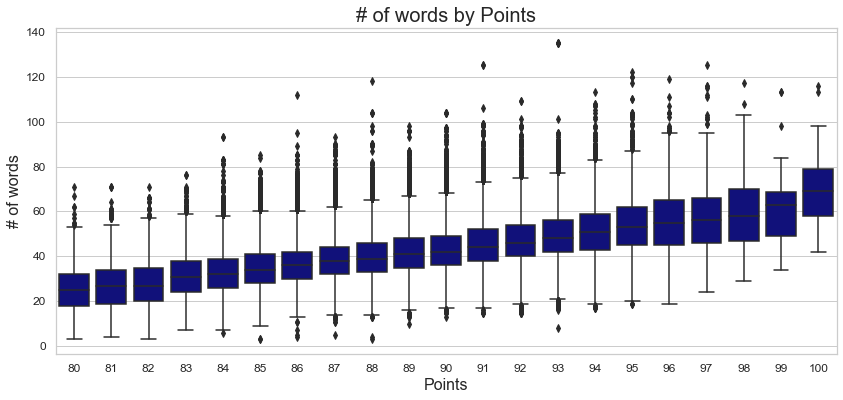

In [27]:
plt.figure(figsize=(14,6))
sns.boxplot(x='points', y='number_of_words', data=df,
                color='darkblue')
plt.title('# of words by Points', fontsize=20)
plt.ylabel('# of words', fontsize = 16) # Y label
plt.xlabel('Points', fontsize = 16) # X label
plt.show()

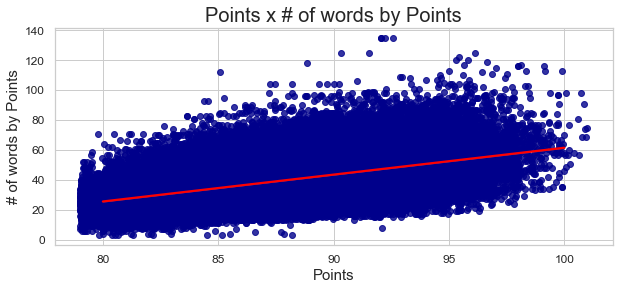

In [28]:
plt.figure(figsize=(10,4))
sns.regplot(x='points', y='number_of_words', 
                data=df, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='darkblue')
plt.title("Points x # of words by Points", fontsize=20)
plt.xlabel("Points", fontsize= 15)
plt.ylabel("# of words by Points", fontsize= 15)

plt.show()

Como esperado o resultado para contabilização de palavras é o mesmo, a tendência é que quanto maior o tamanho da descrição, ou, quanto mais palavras/mais detalhadas ou completas forem as avaliações, melhor tende a ser a nota atribuída ao vinho.

#### Words frequency - Fazendo a mão
##### Calcular a frequência das palavras por meio da criação de um bag of words e TFIDF vectorizer

In [34]:
descricoes = df.description.str.lower()

In [49]:
def split_it(words):
    return re.findall(r'[a-zéóáêâãõç]+', words)
# seleciona apenas letras (lembrando que o texto está em português e as letras possuem acento)
palavras = descricoes.apply(split_it)

In [50]:
todas_as_palavras = [palavra for lista_de_palavras in palavras for palavra in lista_de_palavras]


In [53]:
print(f'Temos um total de: {len(todas_as_palavras)} palavras')

Temos um total de: 11531375 palavras


In [54]:
palavras_unicas = set()

In [55]:
palavras_unicas.update(todas_as_palavras)

In [58]:
palavras_unicas.__len__() #Reduziu para 36 mil palavras

36305

In [59]:
### Criando o dicionário do vocabulário

full_vocab = dict()
i = 0
for word in palavras_unicas:
    full_vocab[word] = i
    i += 1

In [68]:
# Criando uma lista vazia para armazenar as frequências de palavras para cada linha
bow_list = []

# Iterando sobre cada linha da série "palavras"
for lista_palavras in palavras:
    # Inicializando uma lista de frequências de palavras com zeros
    freq_word = [0]*len(full_vocab)
    
    # Contabilizando as frequências de palavras para a linha atual
    for palavra in lista_palavras:
        word_ind = full_vocab[palavra]
        freq_word[word_ind] += 1
    
    # Adicionando a lista de frequências de palavras à lista global
    bow_list.append(freq_word)

MemoryError: 

In [ ]:
# Transformando a lista de listas em um DataFrame
df_bow = pd.DataFrame(bow_list, columns=full_vocab.keys())

#### Utilizando bibliotecas

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

In [44]:
### Avaliando as palavras que melhor descrevem a percepção do vinho a partir da variety

In [47]:
variety = df.variety.value_counts(ascending= False)[:10].index

In [48]:
variety

Index(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
       'Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Riesling', 'Syrah',
       'Merlot', 'Zinfandel'],
      dtype='object')

In [40]:
### TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2, 3), min_df=5, 
                                stop_words='english',
                                max_df=.5) 

In [53]:
X2 = vectorizer.fit_transform(df.loc[(df.variety == 'Pinot Noir')]['description']) 

In [62]:
features = (vectorizer.get_feature_names()) 
scores = (X2.toarray()) 

# Getting top ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 

for col, term in enumerate(features): 
    data1.append( (term, sums[0,col] )) 

c:\Users\joao.paula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


c:\Users\joao.paula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\joao.paula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\joao.paula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\joao.paula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names i

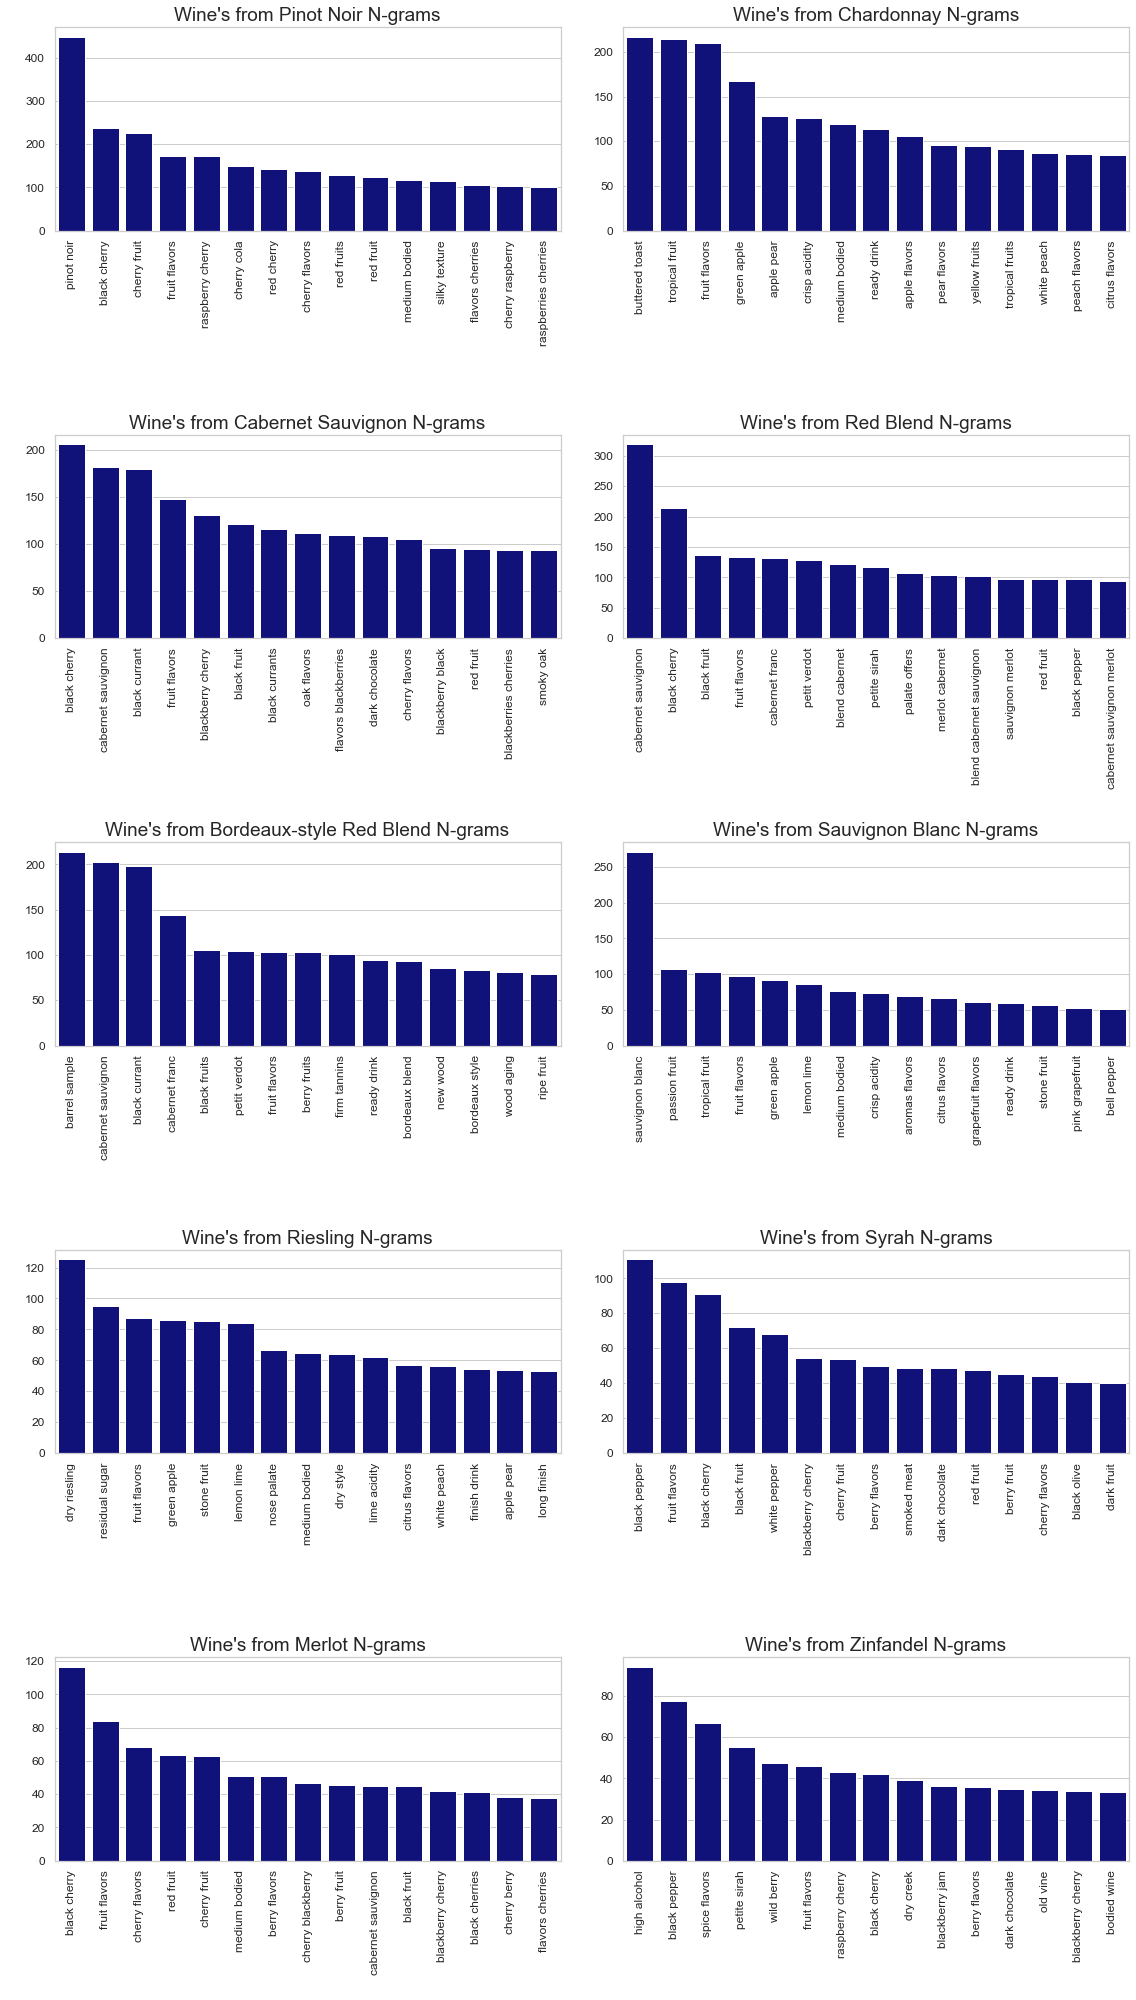

In [71]:
import matplotlib.gridspec as gridspec
grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(16,7*4))
for n, cat in enumerate(variety):
    ax = plt.subplot(grid[n])
    vectorizer = TfidfVectorizer(ngram_range = (2, 3), min_df=5, 
                                stop_words='english',
                                max_df=.5) 
    X2 = vectorizer.fit_transform(df.loc[(df.variety == cat)]['description']) 
    features = (vectorizer.get_feature_names()) 
    scores = (X2.toarray())
    
    # Getting top ranking features 
    sums = X2.sum(axis = 0) 
    data1 = []
    
    for col, term in enumerate(features): 
        data1.append( (term, sums[0,col] ))
    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False))[:15]
    
    sns.barplot(x='term', y='rank', data=words, ax=ax, 
                color='darkblue', orient='v')
    ax.set_title(f"Wine's from {cat} N-grams", fontsize=19)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel(' ')
    ax.set_xlabel(" ")

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.1)
plt.tight_layout()
plt.show()